In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage import transform
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import exposure

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import glob
import os

from tensorflow.keras import losses
from tensorflow.keras import callbacks 
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras import optimizers

In [12]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams.update({'font.size': 16})

In [13]:
PATH_LABELS = "Labels/"
PATH_TRAIN  = "Images_train/"
PATH_TEST = "Images_test/"

In [14]:
class Dataset:
    def __init__(self, img_path, label_path=None):
        self.img_path = img_path
        self.label_path = label_path
        self.X = []
        self.y = []
        
    def load_data(self, load_labels=False):
        """
        Helper method to load the given dataset.
        It allows for loading both the testset 
        and the train set, depending on whether or no
        the load_labels arg is set to True.
        """
        paths_imgs = sorted(glob.glob(self.img_path + "*.tif"))
        for image in paths_imgs: # All train and test images have .tif extension
            self.X.append(io.imread(image, plugin="pil"))
        self.X = np.array(self.X) / 255
        if load_labels:
            paths_labels = sorted(glob.glob(self.label_path + "*.gif"))
            for label in paths_labels: # All labels have .gif extension
                self.y.append(io.imread(label, plugin="pil"))
            self.y = np.array(self.y) / 255
            return self.X, self.y
        return self.X
    
    def _extract_channels(self, image):
        """
        Helper function to extract the color channels
        from a given picture. Channels are extracted
        by setting channel values to 0 for 
        other than the one we want.
        """
        R = np.zeros(image.shape)
        R[:,:,0] = image[:,:,0] 
        G = np.zeros(image.shape)
        G[:,:,1] = image[:,:,1]
        B = np.zeros(image.shape)
        B[:,:,2] = image[:,:,2]
        
        return R, G, B
    
    def visualize_sample(self, i):
        """
        Helper method to  plot the different color channels
        of a training sample, as well as the original sample
        and its label
        """                
        blue = []
        red = []
        green = []

        # Extract channels
        for j in self.X:
            R, G, B = self._extract_channels(j)
            red.append(R)
            green.append(G)
            blue.append(B)
            
        # Determine if we should plot labels
        fig, axs = plt.subplots(2, 3, figsize=(20,20))
        plt.subplots_adjust(hspace=0)
        
        # Start Plotting
        titles = ["Training Sample #{} Color", "Training Sample #{} Red Channel",
                  "Training Sample #{} Green Channel", "Training Sample #{} Blue Channel",
                 "Label for Training Sample #{}", "Training Sample #{} Grey Scale"]
        axs[0,0].axis("off")
        axs[0,0].imshow(self.X[i])
        axs[0,0].set_title(titles[0].format(i+1))
        axs[0,1].axis("off")
        axs[0,1].imshow(red[i])
        axs[0,1].set_title(titles[1].format(i+1))
        axs[0,2].axis("off")
        axs[0,2].imshow(green[i])
        axs[0,2].set_title(titles[2].format(i+1))
        axs[1,0].axis("off")
        axs[1,0].imshow(blue[i])
        axs[1,0].set_title(titles[3].format(i+1))
        axs[1,1].axis("off")
        axs[1,1].imshow(self.y[i], cmap = "gray")
        axs[1,1].set_title("Label for Training Sample #{}".format(i+1))
        gray_scale_img = rgb2gray(self.X[i])
        axs[1,2].axis("off")
        axs[1,2].imshow(gray_scale_img, cmap = "gray")
        axs[1,2].set_title("Training Sample #{} Gray Scale".format(i+1))

In [15]:
data_obj = Dataset(PATH_TRAIN, PATH_LABELS)
X, y = data_obj.load_data(load_labels=True)

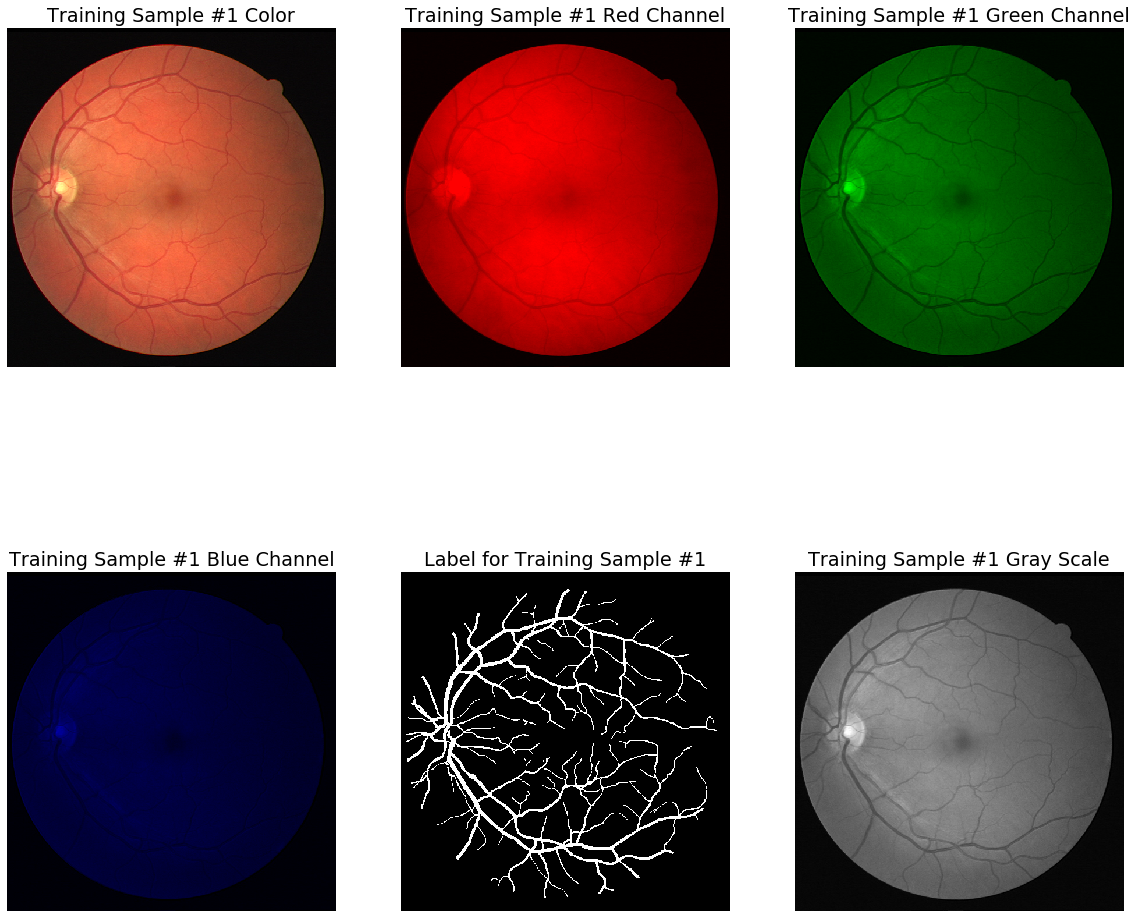

In [16]:
data_obj.visualize_sample(0)

### Check that all images in the train set have the same size 

In [17]:
def check_sizes(images):
    """
    Function to check that all 
    train samples have the same dimensions
    """
    base_shape = images[0].shape
    for image in images:
        if base_shape != image.shape:
            return False
    return True
    
print(check_sizes(X))
print(check_sizes(y))

True
True


In [18]:
class PreProcessor:
    def __init__(self, X, y=None, test=False):
        if not test:
            self.y = y
            self.y_out = None
            self.y_augmented = []
            self.y_scaled = []
        self.X_color = X
        self.X_gray = []
        self.X_out = None
        self.X_augmented = []
        self.X_scaled = []
        self.seen_rotations = []
        
        
    def _convert_to_grayscale(self):
        """
        Helper function to convert dataset images 
        to grayscale. Decreases training time.
        """
        for idx, img in enumerate(self.X_color):
            self.X_gray.append(rgb2gray(img))
        self.X_gray = np.array(self.X_gray)
        return 
    
    def _log_correction(self):
        """
        Helper function to do log correction of the 
        pixel values. Similar effect to gamma correction
        """
        for idx, img in enumerate(self.X_gray):
            self.X_gray[idx] = exposure.adjust_log(img)
        return
    
    def _heq(self):
        """
        Helper function to do histogram equalization.
        make a uniform distribution of the intensity values
        to increase the contrast
        """
        for idx, img in enumerate(self.X_gray):
            self.X_gray[idx] = exposure.equalize_adapthist(img)
        return
        
    def _rotate(self, img, label):
        """
        Helper method to rotate an image randomly
        around its center
        """
        ## Start block to avoid having same transformation
        # done to the same picture twice
        c = 0
        while True:
            rotation_factor = np.random.uniform(0,1)
            if rotation_factor not in self.seen_rotations:
                break
            if c > 100:
                break
            c += 1
        self.seen_rotations.append(rotation_factor)
        ## End Bloc
        # Start rotation
        rotated_X = transform.rotate(img, rotation_factor, order=0)
        rotated_y = transform.rotate(label, rotation_factor, order=0)
        
        return rotated_X, rotated_y
    
    def _augment_data(self):
        """
        Helper method to augment the data and concat
        the augmented data with the original data 
        for increasing training data.
        """
        for i in range(10): # Change this number to decrease the number of training samples.
            for idx, img in enumerate(self.X_gray):
                X_augmented, y_augmented = self._rotate(img, self.y[idx])
                self.X_augmented.append(X_augmented)
                self.y_augmented.append(y_augmented)
            self.seen_rotations = []
            self.seen_shears = []
        self.X_augmented = np.array(self.X_augmented)
        self.y_augmented = np.array(self.y_augmented)
        
        self.X_out = np.concatenate((self.X_gray, self.X_augmented))
        self.y_out = np.concatenate((self.y, self.y_augmented))
        print(self.X_out.shape)
        
        
    def _crop_pad_img(self, img):
        """
        Helper method to crop and pad image
        such that we can feed it through the UNet
        """
        padded = np.zeros((576, 576))
        in_part = 584 - 576
        img = img[in_part:, :]
        padded[:img.shape[0], :img.shape[1]] = img
        return padded.reshape(576,576,1)
    
    
    def preprocess_and_augment_traindata(self):
        # Start preprocessing of numpy arrays #
        self._convert_to_grayscale()
        self._log_correction()
        self._heq()
        self._augment_data()
        for idx in range(len(self.X_out)):
            self.X_scaled.append(self._crop_pad_img(self.X_out[idx]))
            self.y_scaled.append(self._crop_pad_img(self.y_out[idx]))

        return np.array(self.X_scaled), np.array(self.y_scaled)
    
    
    def preprocess_testdata(self):
        self._convert_to_grayscale()
        self._log_correction()
        self._heq()
        for idx in range(len(self.X_gray)):
            self.X_scaled.append(self._crop_pad_img(self.X_gray[idx]))
        return np.array(self.X_scaled)

In [19]:
pre = PreProcessor(X, y)
X, y = pre.preprocess_and_augment_traindata()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1337)

(165, 584, 565)


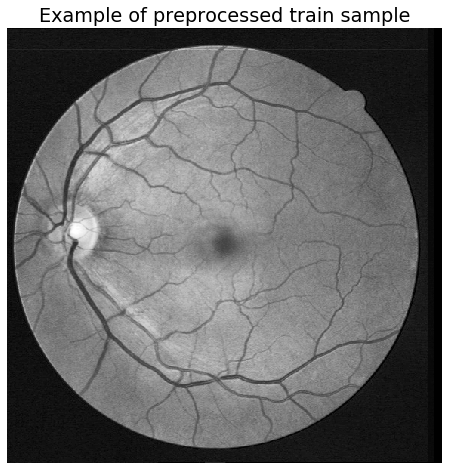

In [20]:
# Plot example of preprocessed data
plt.axis("off")
plt.title("Example of preprocessed train sample")
plt.imshow(X[0].reshape(576, 576), cmap="gray")

### Custoum Loss Function and Metric

In [21]:
def dice_coef_met(labels, preds):
    """
    Helper function to  compute the average dice similarity coefficient
    of the validation set. We have implemented this metric in the
    past, so the implementation is inspired by my own previous implementations.
    However many implementations online are of course very similiar so i 
    will put a reference here for the code:
    Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
    """
    #  Compute the intersection. (TP)
    A_intersect_B = K.sum((labels * preds), axis=[1,2])
    # Compute the cardinality if the individual parts
    # as seen in the assignment text
    size_A = K.sum(labels, axis=[1,2]) 
    size_B = K.sum(preds, axis=[1,2])
    # We multiply the output by two as we would never
    # see a similarity of 1 otherwise. We also take the
    # mean over the batch results. 
    return K.mean((2 * A_intersect_B)/ (size_A + size_B), axis=0)


def dice_coef_loss(labels, preds):
    """
    Helper loss function to optimize relative to the dice coefficient.
    We want to minimize the loss function so we subtract.
    We have implemented this loss function in the
    past, so the implementation is inspired by my own previous implementations
    However many implementations online are of course very similiar so i 
    will put a reference here for the code:
    Source: https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
    """
    return 1-dice_coef_met(labels, preds)

### Helper functions to load saved model

In [22]:
def load_model_and_weights(model_path, weights_path, loss, metrics, optimizer = optimizers.Adam(lr=0.001)):
    """
    Helper function to load the full model 
    from the path of the json object containing the model architecture 
    and a path to the saved weights during training. 
    We also need to specify the loss function, metrics and optimizer
    for when we need to compile the model.
    """
    # Load model arch from json object
    with open(model_path, "r") as f:
        model_json = f.read()
    f.close()
    model = model_from_json(model_json)
    # Load weights
    model.load_weights(weights_path)
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

### Cell for the model class

In [23]:
class UNet:
    def __init__(self, params):
        self.m = None
        self.params = params
        
    def conv_block(self, inp, filter_size):
        """
        Convolutional block that handle the main part of the UNet
        """
        x = layers.Conv2D(filter_size, (3,3), padding='same')(inp)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(self.params["dropout"])(x)
        x = layers.Conv2D(filter_size, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(self.params["dropout"])(x)
        return x
    
    
    def up_across_block(self, prev, earlier, filter_size):
        """
        The up and across blocks combine the deconvolution 
        concatenation of previous layers (the skip connections)
        before being fed through a conv block again. This
        handels it all.
        """
        x = layers.Conv2DTranspose(filter_size, (2,2), strides=(2,2), padding='same')(prev)
        x = layers.Concatenate(axis=-1)([x, earlier])
        x = self.conv_block(x, filter_size)
        return x

        
    def build_model(self,loss=None, metrics=None):
        """
        Method to actually compile the UNet model
        with calls to the relevant helper methods 
        """
        inp = layers.Input(self.params["input_dim"])
        # Start of the down part of UNet
        b1 = self.conv_block(inp, self.params["filter_conv1"])
        p1 = layers.MaxPooling2D()(b1)
        b2 = self.conv_block(p1, self.params["filter_conv2"])
        p2 = layers.MaxPooling2D()(b2)
        b3 = self.conv_block(p2, self.params["filter_conv3"])
        p3 = layers.MaxPooling2D()(b3)
        b4 = self.conv_block(p3, self.params["filter_conv4"])
        p4 = layers.MaxPooling2D()(b4)
        # Bottom section
        b5 = self.conv_block(p4, self.params["filter_conv5"])
        # Up-across section
        b6 = self.up_across_block(b5, b4, self.params["filter_conv4"])
        b7 = self.up_across_block(b6, b3, self.params["filter_conv3"])
        b8 = self.up_across_block(b7, b2, self.params["filter_conv2"])
        b9 = self.up_across_block(b8, b1, self.params["filter_conv1"])
        # out section
        out = layers.Conv2D(1, (1,1))(b9)
        out = layers.Activation("sigmoid")(out)
        # Define model in and outputs
        m = Model(inputs=[inp], outputs=[out])
        # Compile the model
        optimizer = self.params["optimizer"]
        m.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.m = m
        
        
    def train(self, X_train, y_train, X_val, y_val, filename, epochs=100):
        if self.m == None:
            raise("You haven't fitted the model yet...")
        checkpoint = callbacks.ModelCheckpoint( filename + ".hdf5",
                                               save_best_only=True, monitor='val_loss',
                                               verbose=1)
        logger = callbacks.CSVLogger(filename + ".log")
        red_lr = callbacks.ReduceLROnPlateau(factor=0.5, patience = 5, min_lr=0.0000001)
        
        class_w = compute_class_weight("balanced", np.unique(y_train), y_train.flatten())
        with open(filename + ".json", "w") as f:
            f.write(self.m.to_json())
            f.close()
        self.m.fit(X_train, y_train,
                   batch_size=self.params["batch_size"],
                   epochs = epochs,
                   class_weight=class_w,
                   validation_data=(X_val, y_val),
                   callbacks=[red_lr, checkpoint,logger])
        
        
    def predict(self, X):
        """
        Helper predict method. The built in predict method
        in the keras model object does not handle 3 dimensional 
        input so this method takes care of this.
        """
        if len(X.shape) == 3:
            X = X.reshape(-1, X.shape[0], X.shape[1], X.shape[2])
        preds = self.m.predict(X)
        return preds 

### Initialize the model and train it

In [24]:
# Overfit parameters
params_1 = {
    "input_dim" : (576, 576, 1),
    "filter_conv1" : 64,
    "filter_conv2" : 128,
    "filter_conv3" : 256,
    "filter_conv4" : 512,
    "filter_conv5" : 1024,
    "dropout" : 0,
    "optimizer" : optimizers.Adam(lr=0.1),
    "batch_size" : 1
}


# Base params
params_2 = {
    "input_dim" : (576, 576, 1),
    "filter_conv1" : 32,
    "filter_conv2" : 64,
    "filter_conv3" : 128,
    "filter_conv4" : 256,
    "filter_conv5" : 512,
    "dropout" : 0.2,
    "optimizer" : optimizers.Adam(lr=0.001),
    "batch_size" : 2
}


# Extra param set
params_4 = {
    "input_dim" : (576, 576, 1),
    "filter_conv1" : 16,
    "filter_conv2" : 32,
    "filter_conv3" : 64,
    "filter_conv4" : 128,
    "filter_conv5" : 256,
    "dropout" : 0.1,
    "optimizer" : optimizers.SGD(lr=0.001),
    "batch_size" : 5
}



file_names_overfit = "overfit_attempt"
file_names_base = "base_model"
file_names_base_bce = "base_model_bce"
file_names_base_little_data = "base_model_little_data"
file_names_extra_params = "extra_params_model"

### I have commented some of the lines in the cell below otherwise it will start training 5 models. If you wish to train the models simply uncomment the lines.

In [46]:
# Base params
net = UNet(params_2)
net.build_model(loss=dice_coef_loss, metrics=[dice_coef_met])
net.train(X_train, y_train, X_val, y_val, file_names_base)

# Base params little data 
#net = UNet(params_2)
#net.build_model(loss=dice_coef_loss, metrics=[dice_coef_met])
#net.train(X_train[:int(len(X_train)*0.15)], y_train[:int(len(X_train)*0.15)], X_val[:int(len(X_val)*0.15)], y_val[:int(len(X_val)*0.15)], file_names_base_little_data)

# Base params new loss
#net = UNet(params_2)
#net.build_model(loss=losses.binary_crossentropy, metrics=[dice_coef_met])
#net.train(X_train, y_train, X_val, y_val, file_names_base_bce)

# Overfitting Attempt
#net = UNet(params_1)
#net.build_model(loss=dice_coef_loss, metrics=[dice_coef_met])
#net.train(X_train, y_train, X_val, y_val, file_names_overfit)

# Extra paramset
#net = UNet(params_4)
#net.build_model(loss=dice_coef_loss, metrics=[dice_coef_met])
#net.train(X_train, y_train, X_val, y_val, file_names_extra_params)

Train on 132 samples, validate on 33 samples
Epoch 1/100
130/132 [============================>.] - ETA: 0s - loss: 0.5107 - dice_coef_met: 0.4893
Epoch 00001: val_loss improved from inf to 0.83172, saving model to base_model.hdf5
132/132 [==============================] - 28s 213ms/sample - loss: 0.5084 - dice_coef_met: 0.4916 - val_loss: 0.8317 - val_dice_coef_met: 0.1694
Epoch 2/100
130/132 [============================>.] - ETA: 0s - loss: 0.3145 - dice_coef_met: 0.6855
Epoch 00002: val_loss did not improve from 0.83172
132/132 [==============================] - 26s 194ms/sample - loss: 0.3141 - dice_coef_met: 0.6859 - val_loss: 0.9182 - val_dice_coef_met: 0.0821
Epoch 3/100
130/132 [============================>.] - ETA: 0s - loss: 0.2566 - dice_coef_met: 0.7434
Epoch 00003: val_loss did not improve from 0.83172
132/132 [==============================] - 25s 189ms/sample - loss: 0.2561 - dice_coef_met: 0.7439 - val_loss: 0.9833 - val_dice_coef_met: 0.0167
Epoch 4/100
130/132 [====

#### Note that the section below can only be run if all the five models in the cell above have been trained, and the necessary data and model files are present where they  need to be. 

In [25]:
def plot_train_val_loss(log_path):
    """
    Helper function to plot the train and validation loss
    from the saved log file keeping the train history
    """
    # Read log with pandas 
    df = pd.read_csv(log_path)
    # Start plotting with pandas and matplotlib backend
    ax = plt.gca()
    df.plot(kind="line", x="epoch", y="loss", ax=ax, title="Loss vs Epoch", figsize=(10,10))
    df.plot(kind="line", x="epoch", y="val_loss", ax=ax)
    plt.show()
    return
    
def reshape_and_pad_preds(img):
    """
    Helper function to repad to removed black parts in the preprocessing 
    and remove the padded black parts. Handles only images whose output 
    size should be (584, 565)
    """
    out = np.zeros((584, 576, 1))
    in_part = 584 - 576
    out[in_part:,:] = img
    out = out[:, :565]
    return (out > 0.49).astype(np.uint8).reshape(584, 565)

def save_predictions(imgs, save_path="./"):
    """
    Helper function to save the predictions to 
    images with the same name as the input. 
    """
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    for i in range(len(imgs)):
        io.imsave(save_path + "{}_test.tif".format(i+1), imgs[i]*255, plugin="pil")
    print("Saved all images in {}".format(save_path))
    return

### Cells for plotting the losses  

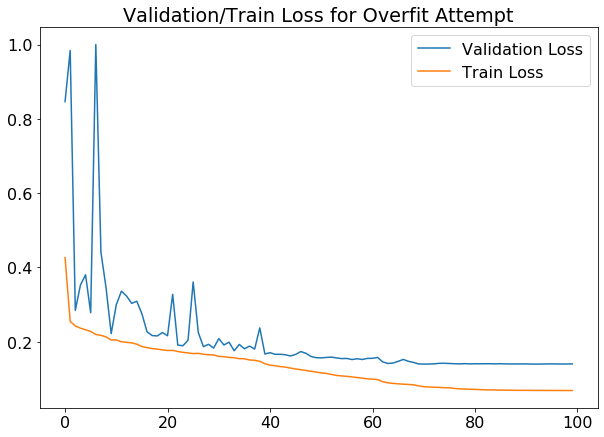

In [16]:
# Plot overfitting
df = pd.read_csv(file_names_overfit + ".log")

epoch_num = df.epoch.values
val_loss = df.val_loss.values
loss = df.loss.values
fig, axs = plt.subplots(1, 1, figsize=(10,7))
axs.plot(epoch_num, val_loss,label="Validation Loss")
axs.plot(epoch_num, loss, label="Train Loss")
axs.set_title("Validation/Train Loss for Overfit Attempt")
axs.legend()

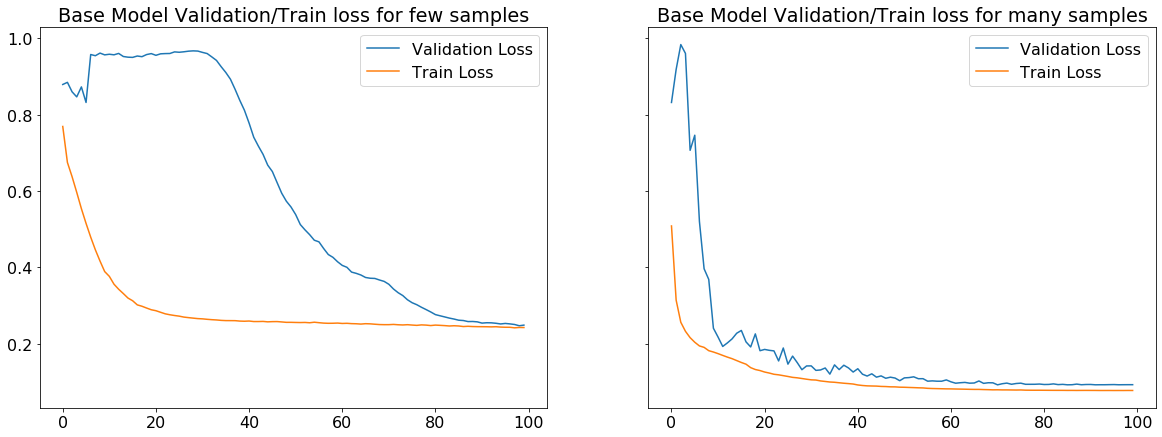

In [26]:
## Plot validation and training loss for dice loss with much data and little data
df_ld = pd.read_csv(file_names_base_little_data + ".log")
df_md = pd.read_csv(file_names_base + ".log")

epoch_num = df_ld.epoch.values
val_loss_ld = df_ld.val_loss.values
loss_ld = df_ld.loss.values
val_loss_md = df_md.val_loss.values
loss_md = df_md.loss.values

fig, axs = plt.subplots(1, 2, figsize=(20,7), sharey=True)
axs[0].plot(epoch_num, val_loss_ld,label="Validation Loss")
axs[0].plot(epoch_num, loss_ld, label="Train Loss")
axs[0].set_title("Base Model Validation/Train loss for few samples")
axs[0].legend()
axs[1].plot(epoch_num, val_loss_md, label="Validation Loss")
axs[1].plot(epoch_num, loss_md, label="Train Loss")
axs[1].set_title("Base Model Validation/Train loss for many samples")
axs[1].legend()

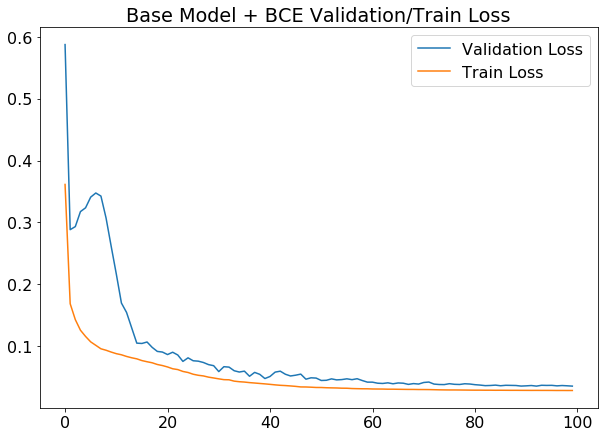

In [18]:
# Plot the train and validation loss for base model with binary cross entropy as loss function
# Plot overfitting
df = pd.read_csv(file_names_base_bce + ".log")

epoch_num = df.epoch.values
val_loss = df.val_loss.values
loss = df.loss.values
fig, axs = plt.subplots(1, 1, figsize=(10,7))
axs.plot(epoch_num, val_loss,label="Validation Loss")
axs.plot(epoch_num, loss, label="Train Loss")
axs.set_title("Base Model + BCE Validation/Train Loss")
axs.legend()

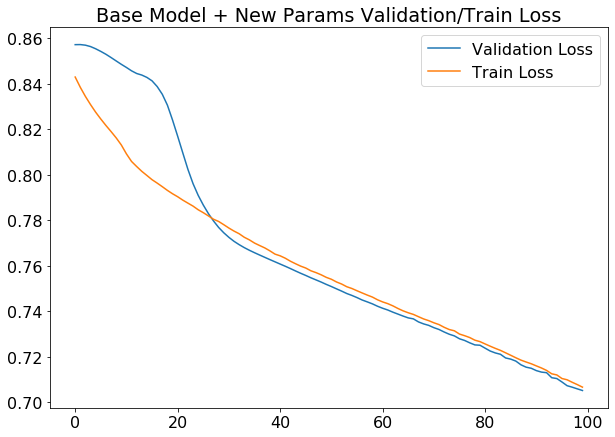

In [19]:
# Plot the train and validation loss for base model with a different parameter set
# Plot overfitting
df = pd.read_csv(file_names_extra_params + ".log")

epoch_num = df.epoch.values
val_loss = df.val_loss.values
loss = df.loss.values
fig, axs = plt.subplots(1, 1, figsize=(10,7))
axs.plot(epoch_num, val_loss,label="Validation Loss")
axs.plot(epoch_num, loss, label="Train Loss")
axs.set_title("Base Model + New Params Validation/Train Loss")
axs.legend()

### Load the best model (base model) and make predictions on the test set 

In [27]:
# Load the model 
loaded_model = load_model_and_weights(file_names_base + ".json", file_names_base + ".hdf5", dice_coef_loss, [dice_coef_met])

In [28]:
# Load the test dataset
data_obj = Dataset(PATH_TEST)
X_test = data_obj.load_data(load_labels=False)

# Preprocess the test dataset
pre = PreProcessor(X_test, test=True)
X_test = pre.preprocess_testdata()

In [29]:
# Make predictions on the test data
preds = loaded_model.predict(X_test)

In [30]:
# Repad and crop predictions to fit original image shape
preds_reshape = []
for i in range(len(preds)):
    preds_reshape.append(reshape_and_pad_preds(preds[i]))

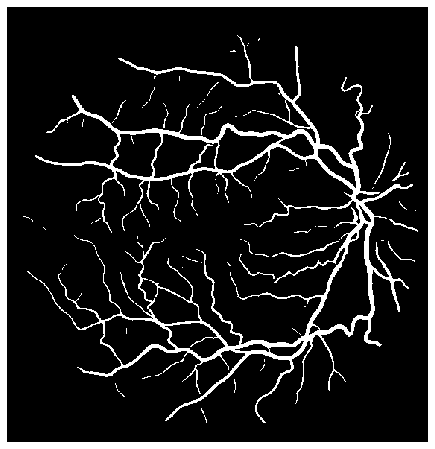

In [31]:
# Visualize a prediction
plt.axis("off")
plt.imshow(preds_reshape[0], cmap="gray")

### Save predictions to .tif files

In [77]:
save_predictions(preds_reshape, save_path="./predictions/")

Saved all images in ./predictions/
